<a href="https://colab.research.google.com/github/edu-rinaldi/asm-function-classificator-ml/blob/main/asm_functions_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

External libraries:

In [ ]:
import json
import ast

from sklearn.model_selection import *
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

import matplotlib.pyplot as plt

import numpy as np

print("External libraries imported.")

External libraries imported.


**Utility functions:**

In [ ]:
def find_root(cfg):
    """
    Find a root node for the given cfg
    """
    toVisit = set()
    for adj in cfg['adjacency']:
        for n in adj:
            toVisit.add(n['id'])
    for i in range(len(cfg['nodes'])):
        if cfg['nodes'][i]['id'] not in toVisit:
            return i
    return 0
    
def indexByIdMap(cfg):
    """
    Function that returns the dictionary that returns the index of a certain node given the ID.
    """
    return {cfg['nodes'][i]['id']:i for i in range(len(cfg['nodes']))}
    
def tarjan(cfg):
    """
    Python implementation of tarjan algorithm based to be used on the cfg.
    """
    indexById = indexByIdMap(cfg)
    index = 0
    indexes = [-1 for _ in cfg['nodes']]
    lowlinks = [-1 for _ in cfg['nodes']]
    onStack = [False for _ in cfg['nodes']]
    components = []
    s = []

    def strongconnect(v):
        nonlocal index
        indexes[v] = index
        lowlinks[v] = index
        index+=1
        s.append(v)
        onStack[v] = True
        for w in cfg['adjacency'][v]:
            w = indexById[w['id']]
            if indexes[w] == -1:
                strongconnect(w)
            elif onStack[w]:
                lowlinks[v] = min(lowlinks[v], indexes[w])
        
        if lowlinks[v] == indexes[v]:
            component = []
            while True:
                w = s.pop()
                onStack[w] = False
                component += [w]
                if w == v:
                    break
            components.append(component)

    for v in cfg['nodes']:
        v = indexById[v['id']]
        if indexes[v] == -1:
            strongconnect(v)

    return components
    
def get_features(list_asm, cfg, normalization_func=lambda x: x):
    """
        :params list_asm: list of asm instructions
        :returns a list such that [#bitwiseOPs, #movOPs, #xmmm*, #arithmeticOPs, #cmpOPs, #swapOPs, #loops, #maxComplexity]
    """
    bitwise = {'xor', 'shift', 'pxor', 'xorps', 'sal', 'shl', 'sar', 'not', 'and', 'pand', 'or', 'por'}
    mov = 'mov'
    xmm = 'xmm'
    arithmetic = {'add', 'mul', 'neg', 'sub', 'imul', 'idivl', 'divl', 'idivq', 'divq', 'idiv', 'divsd', 'div'}
    comp = 'cmp'
    swap = 'bswap'
    
    # initialize final list to return
    final = [0,len(list_asm),0,0,0,0,0]
    for instruction in list_asm:
        instruction_splitted = instruction.split(" ")

        # get instruction type
        if instruction_splitted[0] in bitwise:
            final[0] += 1
        if instruction.startswith(mov):
            final[2] += 1
        if xmm in instruction:
            final[3] += 1
        if instruction_splitted[0] in arithmetic:
            final[4] += 1
        if instruction.startswith(comp):
            final[5] += 1
        if instruction.startswith(swap):
            final[6] += 1
    # get list of components in the graph
    components = tarjan(cfg)
    loops = 0
    maxComplexity = 0
    for component in components:
        lenComp = len(component)
        # if there're at least 2 nodes in a component --> there's a loop 
        if lenComp >= 2:
            loops += 1
            # n nodes in a component --> n-1 nested loops
            maxComplexity = max(maxComplexity, lenComp-1)

    final.extend([loops, maxComplexity])
    return list(map(normalization_func,final))

# Loading the dataset from the jsonl

In [ ]:
# class mapping : string -> {0,...,n}, n = 3
classByVal = {0: 'encryption', 1 : 'sort', 2 : 'math', 3 : 'string'}
valByClass = {'encryption' : 0, 'sort' : 1, 'math' : 2, 'string': 3}

# reading jsonl and preparing dataset

dataset_path = 'noduplicatedataset.json' # 'dataset.json' or 'noduplicatedataset.json'

data = []
print('Preparing the dataset...')
with open(dataset_path, 'r') as f:
    for e in f:
        v = json.loads(e)
        # get_features(x) = fi(x) 
        row = get_features(ast.literal_eval(v['lista_asm']), v['cfg'])
        row.append(valByClass[v['semantic']])
        data += [row]

# convert to numpy array
data = np.array(data)

# extract X and y from data

# Use this for applying log
X_all = np.log2(data[:,:-1]+1)

#X_all = data[:,:-1]
y_all = data[:, -1]

print("X:\n", X_all)
print("\ny:\n", y_all)

Preparing the dataset...
X:
 [[0.         6.50779464 5.67242534 ... 0.         0.         0.        ]
 [2.32192809 5.52356196 3.169925   ... 0.         0.         0.        ]
 [7.33091688 9.00842862 7.53915881 ... 0.         1.         1.        ]
 ...
 [6.20945337 9.33985    7.72792045 ... 3.         3.32192809 1.5849625 ]
 [2.80735492 5.78135971 4.64385619 ... 0.         0.         0.        ]
 [0.         6.24792751 4.7548875  ... 0.         1.         1.5849625 ]]

y:
 [3 2 0 ... 0 2 1]


# Splitting the data

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=117)
print("Splitting completed.")

Splitting completed.


# Training models

SVM

In [ ]:
# SVM  ~0.863 accuracy
model = svm.SVC(kernel='linear', C=1)

Decision Tree

In [ ]:
# Decision Tree ~0.95 accuracy
model = tree.DecisionTreeClassifier()

# Training the chosen model

In [ ]:
print("\n--- Using",type(model).__name__, "model ---\n")

model.fit(X_train, y_train)
print("Fit completed.")


--- Using SVC model ---

Fit completed.


# Prediction

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

[2 3 2 ... 0 0 2]


# Accuracy scores

Some basics metrics as : **precision**, **recall**, **f1-score**, **support**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       881
           1       0.80      0.88      0.84      1339
           2       0.93      0.94      0.93      1450
           3       0.81      0.76      0.78      1082

    accuracy                           0.86      4752
   macro avg       0.87      0.85      0.86      4752
weighted avg       0.86      0.86      0.86      4752



# Confusion matrix

In [ ]:
confusion_matrix(y_test, y_pred)

array([[341,   5,   6,   8],
       [  4, 137,   4,  25],
       [  0,   3, 782,   4],
       [  0,  20,   8, 658]])

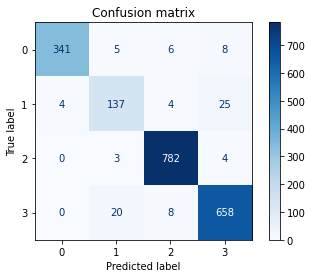

In [ ]:
matrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format='')
matrix.ax_.set_title("Confusion matrix", color="black")
plt.show()

